In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Adaptive dynamics
## Erol Akçay
### University of Pennsylvania, Biol 417 Spring 2019

## Resource exploitation model: analytics

Let us consider a model where a population is adapting to exploit a resource whose distribution is exogenously fixed (example due Lehmann, 2015). Suppose the resource is characterized by a continuous variable $x$ (e.g., prey of different size, where the variable is prey size). Assume that the abundance of resource $x$ is described by a Gaussian:
$$
A(x)=A_{max} e^{-\frac{(x-\hat{x})^2}{2\sigma_x^2}}\:,
$$
where $A_{max}$ is the maximum resource abundance, which happens at $x=\hat{x}$, and $\sigma_x$ denotes the "width" of the resource distribution. 

Below is a plot with $A_{max}=1$, $\hat{x}=0.5$ and $\sigma_x=0.1$

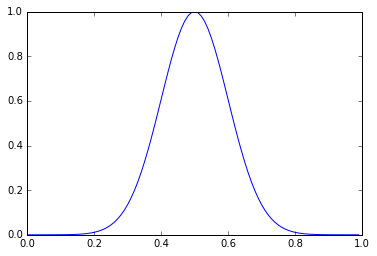

In [2]:
plt.plot(np.arange(0,1,.01),np.exp(-(np.arange(0,1,.01)-.5)**2/(2*0.1**2)))

Now, we assume that each individual has a trait $z$ that denotes with resource is "prefers," i.e., is most adept at using. In particular, we will assume that the relative utilization rate of a resource $z$ by an individual with trait $z$ is given by another Gaussian:
$$
U(z,x)=e^{-\frac{(x-z)^2}{2\sigma_u^2}}\:,
$$
which peaks at $x=z$. Here, $\sigma_u$ gives how wide the resource utilization function is: larger $\sigma_u$ corresponds to wider functions, in other words, generalists.

Finally, let us assume that the actual amount of resource $x$ taken up by a given individual with trait $z$ is its relative utilization rate divided by that of everyone else for $x$. In a population of size $N$ fixed by trait $z_r$, this becomes:
$$
h(z,x,z_r)=\frac{U(z,x)}{N U(z_r,x)}=\frac{1}{N} e^{-\frac{(x-z)^2-(x-z_r)^2}{2\sigma_u^2}}\:,
$$
where we should've written $N-1$ in the denominator but assume that $N\gg 1$ so ignore the difference between $N-1$ and $N$. Note that we assumed that the width of the resource utilization function ($\sigma_u$) is the same for both the resident and the mutant; they only differ in where the peak is.

The total resource utilization of a mutant with trait $z$ in a population fixed for $z_r$ is given by the integral of $h(z,x,z_r)$ over $x$, weighted by the overall abundance of the resorce, A(x):
$$
H(z,z_r)=\int A(x) h(z,x,z_r)dx
$$
which we can evaluate using sympy (we'll ignore $N$ for the time being, since we will set that to be a constant):

In [3]:
from sympy import *
x, z, zr, ss, sx, amax, xhat= symbols('x z z_r sigma_u sigma_x A_max xhat')
init_printing()

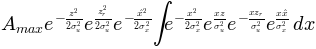

In [4]:
integrate(amax*exp(-( (x-z)**2-(x-zr)**2)/(2 * ss**2)-(x-xhat)**2/(2*sx**2)), x)

Or not. Seems like sympy can't actually evaluate this integral. However, Mathematica can, and finds:
$$
H(z,z_r)=\sqrt{2 \pi } \sigma_x  \exp \left(-\frac{\left(z-z_r\right) \left(\sigma_s^2 \left(z_r-2
  \hat{x}+z\right)+\sigma_x^2 \left(z_r-z\right)\right)}{2 \sigma_s^4}\right)
$$

Now let's assume that the population size is constant (e.g., because there are finite breeding sites), but the fecundity of individuals depends on the total resource use. Then, the invasion fitness of a mutant is:
$$
w(z,z_r,N)=\frac{H(z,z_r)}{H(z_r,z_r)}=\exp \left(-\frac{\left(z-z_r\right) \left(\sigma_s^2 \left(z_r-2
  \hat{x}+z\right)+\sigma_x^2 \left(z_r-z\right)\right)}{2 \sigma_s^4}\right)
$$
Now we can calculate the selection gradient:

In [5]:
der = diff(exp(-(z-zr)*(ss**2*(zr-2*xhat+z)+sx**2*(zr-z))/(2*ss**4)),z)

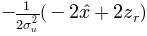

In [6]:
der.subs(z, zr)

This means that the selection gradient is positive whenever $z_r<\hat{x}$, and negative whenever $z_r>\hat{x}$. Thus, we can conclude that the population trait value will converge to the resource with maximum abundance. This is not very surprising. But what happens next might be more surprising.

Let us calculate the second order uninvadability condition at the candidate uninvadable strategy:
$$
\left.\frac{\partial^2 w(z,z_r,N)}{\partial z^2}\right|_{z=z_r=\hat{x}}
$$

In [7]:
der2 = diff(exp(-(z-zr)*(ss**2*(zr-2*xhat+z)+sx**2*(zr-z))/(2*ss**4)), z, 2)

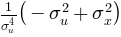

In [8]:
der2.subs(z,zr).subs(zr,xhat)

The second derivative is positive when $\sigma_x>\sigma_u$. Thus, we might have a convergent stable strategy that is nonetheless not uninvadable.

## Resource exploitation model: simulation

The above analysis suggests that the population will evolve towards $\hat{x}$ but that point might or might not be stable depending on the variances. Let us simulate an evolutionary trajectory to see what happens. First let's define the invasion fitness function.

In [9]:
def invfit(z,zr,ss,xhat,sx):
    return exp(-(z-zr)*(ss**2*(zr-2*xhat+z)+sx**2*(zr-z))/(2*ss**4))

In [10]:
invfit(.4,.3,.2,.5,.2)

Now define a function that draws a mutant, compares its invasion fitness against the resident, and returns the mutant if the invasion fitness is greater than 1, the resident otherwise.

In [11]:
def mutantinv(zr,sm,ss,xhat,sx):
    mut = zr+np.random.normal(0,sm) #draw the mutant trait from a gaussian centered around the resident, with SD sm
    if invfit(mut,zr,ss,xhat,sx)>1:
        return np.array([[mut,mut]]) # the output is an array, the first element is the traitvalue that succeeds (mutant or resident), the second is always the mutant.
    else:
        return np.array([[zr,mut]])

In [12]:
mutantinv(.4,.3,.2,.5,.1)

array([[ 0.4      ,  0.3065289]])

Now we are ready to simulate the evolutionary history of the population.

In [13]:
def evolhist(init,sm,ss,xhat,sx,nit):
    hist=np.array([[init, init]])
    for i in range(nit):
        hist=np.concatenate((hist,mutantinv(hist[-1,0],sm,ss,xhat,sx)))
    return(hist)

In [14]:
adaphist = evolhist(.2,.01,.1,.5,.2,1000)

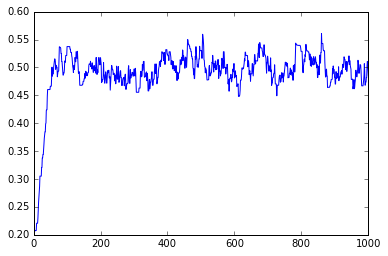

In [15]:
plt.plot(adaphist[:,0])

Now this kind of modeling is called a trait-substitution sequence. It is a computationally efficient way of visualizing the trajectory of a population in evolutionary time. But it is directly reliant on the simplifying assumptions we made for the analytical approximation (importantly that there are only two types of individuals present, and invasion implies fixation). So it won't tell us more than what the analytical treatment can say (although it can be useful when the analytical treatment is intractable). To go beyond those assumptions, we need an individual-based model. 

## Resource competition: individual-based model

Now we let each individual to gave a different trait value. In principle, this would mean that now we have to do the integration above for many many z values (each weighted by the number of individuals carrying them), which is a bit tedious (though it could probably be done numerically). Instead, we will now assume everyone competes against the mean.

First, let us define a population of 1000 individuals, characterized by their z-values, by drawing them from a normal distribution.

In [16]:
pop = np.random.normal(.3,.01,1000)

We can use the invasion fitness above to denote the relative success, and pick one with probability proportional to that success to replace the other.

In [17]:
popmean = np.mean(pop)
relsucc = [invfit(pop[i], popmean,.2,.5,.2) for i in range(1000)]
relsucc = np.ndarray.tolist(np.array(relsucc)/sum(relsucc))

In [18]:
newpop = np.random.choice(pop,1000,p=relsucc)
newpop = newpop.reshape(1000)+ np.random.normal(0,.05,1000)*np.random.binomial(.02,1,1000)

Ok, now let's collect all this stuff in a function.

In [19]:
def popiterate(pop,mutrate,mutvar,ss,xhat,sx):
    popsize = len(pop)
    popmean = np.mean(pop)
    relsucc = [invfit(pop[i], popmean,ss,xhat,sx) for i in range(popsize)]
    relsucc = np.ndarray.tolist(np.array(relsucc)/sum(relsucc))
    newpop = np.random.choice(pop, popsize, p=relsucc)
    return newpop + np.random.normal(0,mutvar,popsize)*np.random.binomial(1,mutrate,popsize)

In [20]:
def evolvepop(init, mutrate, mutvar, ss,xhat,sx, nit):
    pophist=[init]
    for j in range(nit):
        newpop = popiterate(pophist[-1],mutrate,mutvar,ss,xhat,sx)
        pophist.append(newpop)
    return pophist

In [21]:
ibevolhist = evolvepop(pop,1,.02,.2,.5,.1,200)

Now let's visualize the population. First, plot the means.

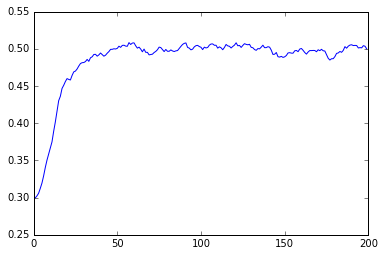

In [22]:
plt.plot([np.mean(ibevolhist[i]) for i in range(200)])

Now let's look at the distribution of the traits in the population. 

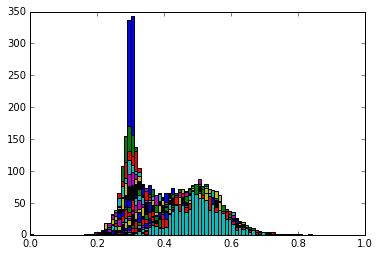

In [23]:
hists = [plt.hist(ibevolhist[i], bins=np.arange(0,1,.01))[0] for i in range(200)];

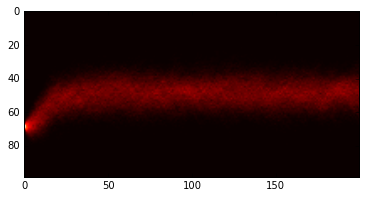

In [24]:
plt.imshow(np.transpose(np.fliplr(np.array(hists))),cmap='hot')

The above simulation is when $\sigma_x<\sigma_u$, where the second order condition is satisfied. Let's see what happens when it isn't.

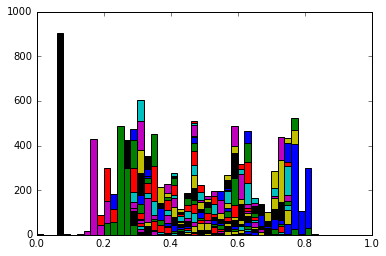

In [28]:
ibevolhist = evolvepop(pop,.02,.02,.2,.5,.25,500)
hists = [plt.hist(ibevolhist[i], bins=np.arange(0,1,.02))[0] for i in range(0,500,5)];

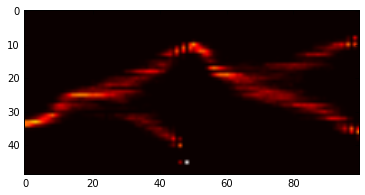

In [29]:
plt.imshow(np.transpose(np.fliplr(np.array(hists))),cmap='hot')

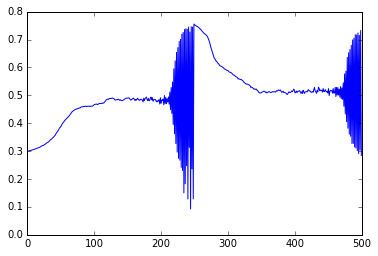

In [30]:
plt.plot([np.mean(ibevolhist[i]) for i in range(500)])

What we observe is an evolutionary branching: the population first approaches the evolutioanry singular point (our candidate uninvadable strategy), but as it gets close to that point, trait values to either side of the population mean start having higher and higher fitness. This increases the population variance, until the population splits into a bi-modal distribution. The two "subpopulations" (remember though that they are still competing against the mean) continue to diverge. Depending on which sub-population has an advantage, the mean of the entire population also starts to oscillate widely. 

At some point in the above simulation, the oscillations get big enough that one of the sub-populations (which after all, are finite) goes extinct (or functionally so), and only one of the modes remain. From that point on, the dynamics return to the beginning: a steady convergence to $\hat{x}$, followed by increasing variance and branching.